# Heatmap
### Read in final tract/code/score combos
### Use the census tract shape files to make a map of SD w/ tract boundaries
### For each code, color code the map and save it as a .jpg

In [2]:
# imports
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
import shapefile as sf
from pyproj import Proj
from matplotlib import cm
from numpy.random import randn

%matplotlib inline

In [4]:
# read in dataframe of tracts and scores
df_scores_all = pd.read_csv('data_final/tracts_scores.csv',index_col=0)

# test looking up a score given a tract and code
tract = 9104
# get correct row of dataframe
score_row = df_scores_all[df_scores_all.census_tract==tract].score
# get score itself
score = score_row.values[0]
print score
print min(df_scores_all.score)
print max(df_scores_all.score)

62.3918711519
0.0
99.9930655732


In [5]:
# read in shapefile
mc_reader = sf.Reader('data/CENSUS_TRACTS_2010/CENSUS_TRACTS_2010.shp')
mc_records = pd.DataFrame(mc_reader.records())
mc_shapes = mc_reader.shapes()

# save tracts from shape file
mc_tracts = np.round(mc_records[0].values*100)
print len(mc_records)
print len(mc_shapes)
print len(mc_tracts)

627
627
627


# tracts/patches plotted: 313 for code all
# tracts w/ scores: 313


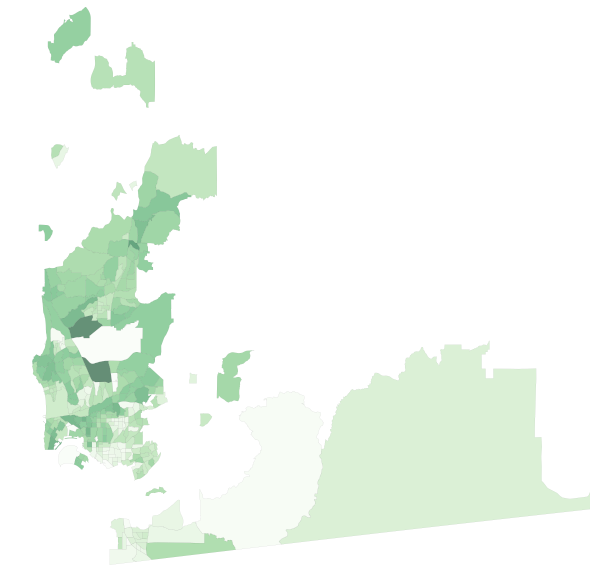

# tracts/patches plotted: 313 for code 54
# tracts w/ scores: 288


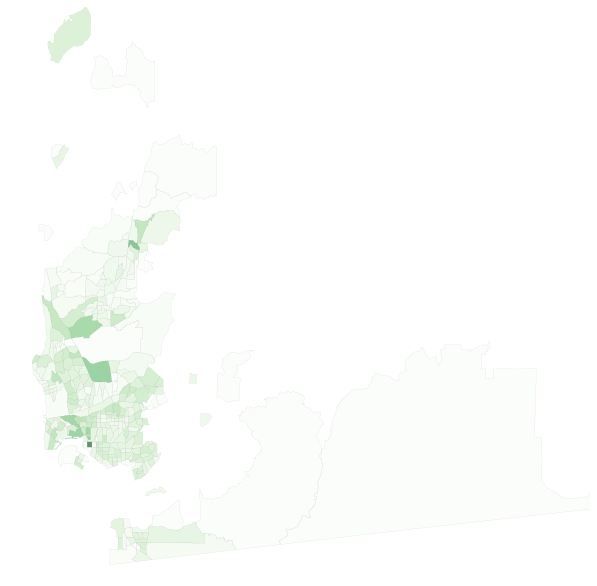

# tracts/patches plotted: 313 for code 81
# tracts w/ scores: 280


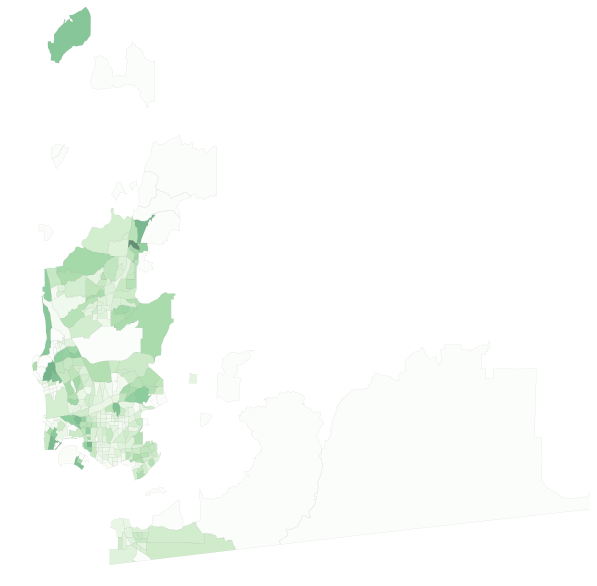

# tracts/patches plotted: 313 for code 45
# tracts w/ scores: 270


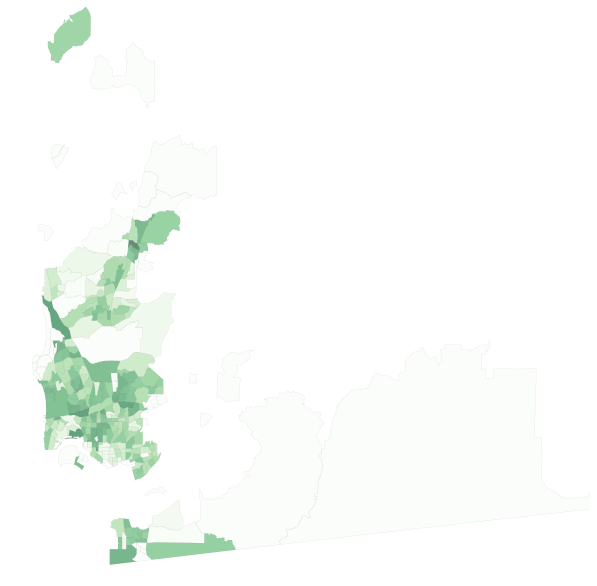

# tracts/patches plotted: 313 for code 62
# tracts w/ scores: 260


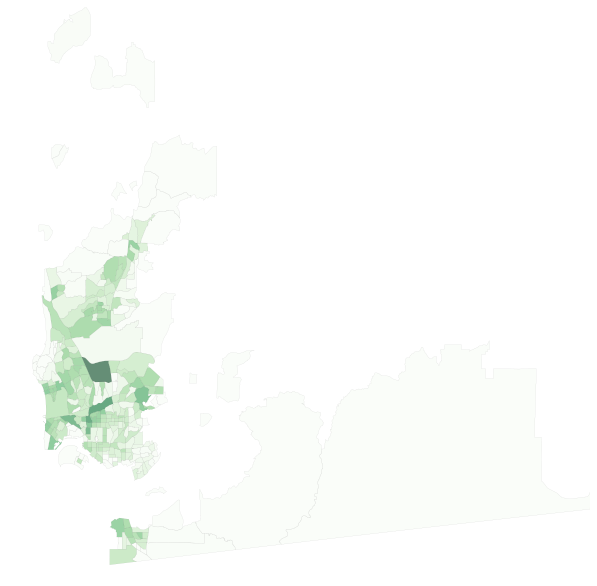

# tracts/patches plotted: 313 for code 56
# tracts w/ scores: 266


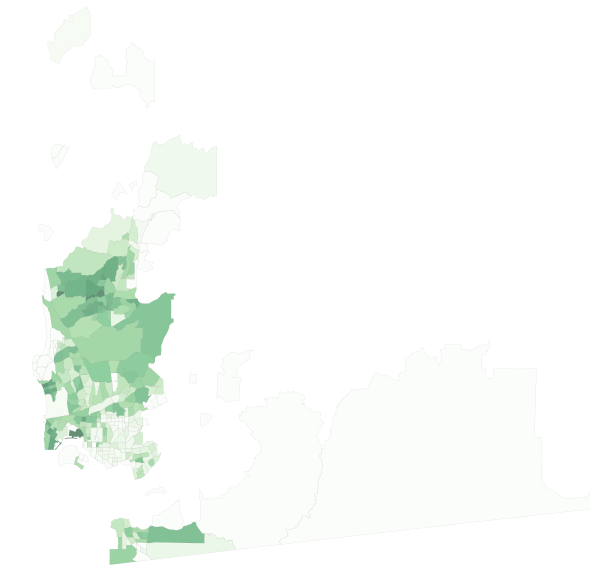

# tracts/patches plotted: 313 for code 44
# tracts w/ scores: 255


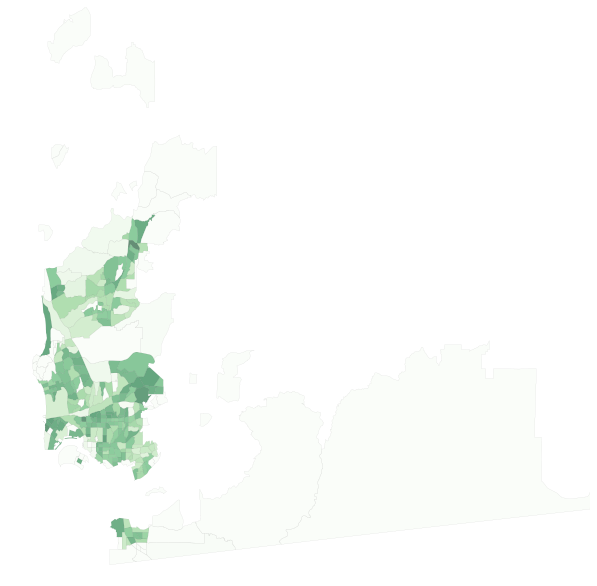

# tracts/patches plotted: 313 for code 72
# tracts w/ scores: 245


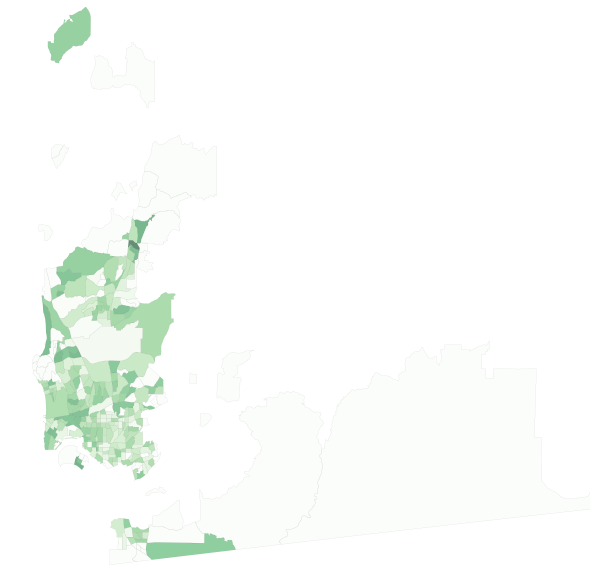

# tracts/patches plotted: 313 for code 53
# tracts w/ scores: 249


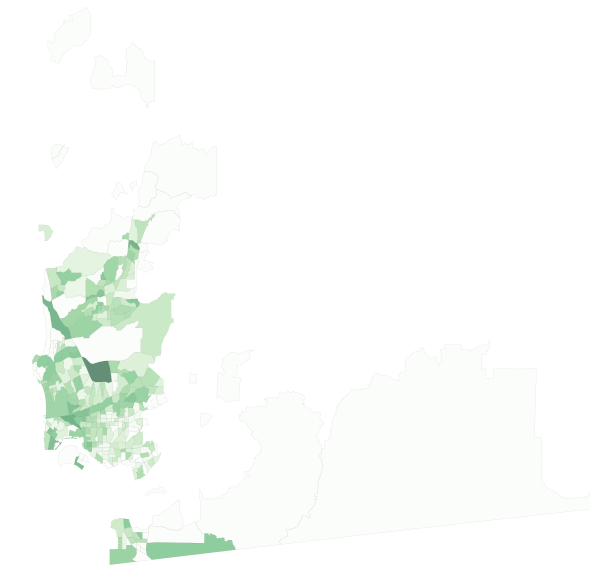

In [7]:
# convert shapefile from XY to lat/lon
p1 = Proj("+init=EPSG:2230", preserve_units=True)

# define list of codes (and 'all')
codes = ['all','54','81','45','62','56','44','72','53']

# go through each code
for code in codes:

    # read in dataframe of tracts and scores
    if code != 'all':
        df_scores = pd.read_csv('data_final/tracts_scores_'+code+'.csv',index_col=0)
    else:
        df_scores = pd.read_csv('data_final/tracts_scores.csv',index_col=0)

    # plot shapefile outlines
    fig,ax = plt.subplots(1,1, figsize=(10,10))

    # initialize list of patches # of patches
    patches = []
    scores = []
    count = 0
    actual_count = 0

    # go through each shape/tract
    for i in range(0,len(mc_shapes)):
        # if it's a tract we have any businesses in
        if mc_tracts[i] in df_scores_all.census_tract.values:
            # save the points of the shape
            temp = pd.DataFrame(mc_shapes[i].points)
            # convert XY to lon/lat
            lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)

            # if it's a tract that we have a score for
            if mc_tracts[i] in df_scores.census_tract.values:
                # find score for current tract
                score_row = df_scores[df_scores.census_tract==mc_tracts[i]].score
                score = score_row.values[0]
                # convolve score with logistic function
                scaled_score = score#/(1+3/np.std(df_scores.score)* \
                #                      np.exp(-2/np.std(df_scores.score)*(score-np.mean(df_scores.score))))
                scores.append(scaled_score)
                actual_count+=1
            else:
                scores.append(0.)
        
            # define the polygon for the tract
            poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='none', lw=.1, alpha=1.0)
            # save the patch
            patches.append(poly)
        
            # plot the patch/tract
            #plt.gca().add_patch(poly)
        
            # count the tract
            count+=1

    # set up color table
    p = PatchCollection(patches, cmap='Greens', alpha=0.6, lw=0.05, edgecolor='k')
    p.set_array(np.array(scores))
    #p.set_clim([min(scores),max(scores)])
    p.set_clim([min(df_scores.score),max(df_scores.score)])

    # add colors to patches
    ax.add_collection(p)

    # tighten the axis ranges
    ax.axis('tight')
    # turn off axes
    plt.axis('off')
    print '# tracts/patches plotted: '+str(count)+' for code '+str(code)
    print '# tracts w/ scores: '+str(actual_count)
    plt.savefig('wheresious/static/map_'+str(code), bbox_inches='tight', transparent=True, dpi=800, frameon=False);
    plt.show()
#print plt.xlim()
#print plt.ylim()

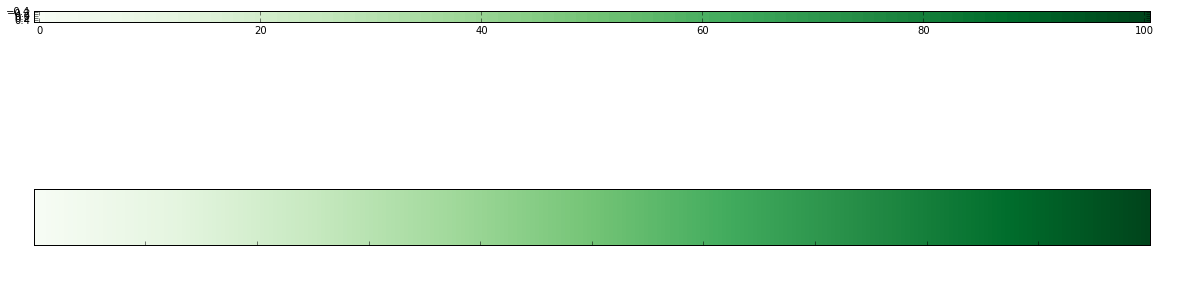

In [9]:
# Make plot with horizontal colorbar
fig,ax = plt.subplots(1,1, figsize=(20,20))
data = np.arange(0,101).reshape((1, 101))
cax = ax.imshow(data, interpolation='nearest', cmap='Greens')
cbar = fig.colorbar(cax,orientation='horizontal')
cbar.ax.tick_params(labelsize=35,labelcolor='w')
plt.show()